In [9]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import factorial
from scipy.stats import poisson
import matplotlib.pyplot as plt

In [ ]:
class MMmBQueue:
    def __init__(self, m, B, lam, mu):
        self.m = m
        self.B = B
        self.lam = lam
        self.mu = mu  # effective mu updated outside based on return rate r(q)
        self.update_rho()

    def update_rho(self):
        self.rho = self.lam / self.mu

    def p0(self):
        rho_m = self.m * self.rho
        sum_pn = sum([rho_m**n / factorial(n) for n in range(1, self.m)])
        part_c = (1 - self.rho**(self.B - self.m + 1)) * rho_m**self.m / (factorial(self.m) * (1 - self.rho))
        return 1 / (1 + part_c + sum_pn)

    def p_n(self, n):
        if n == 0:
            return self.p0()
        elif n <= self.m:
            return (self.m * self.rho)**n / factorial(n) * self.p0()
        else:
            return (self.m * self.rho)**n / (factorial(self.m) * self.m**(n - self.m)) * self.p0()

    def expected_nq(self):
        return sum([(n - self.m) * self.p_n(n) for n in range(self.m + 1, self.B + 1)])

In [21]:
class Server:
    def __init__(self, index, lam, m, B, initial_mu, initial_q, p):
        self.index = index
        self.queue = MMmBQueue(m, B, lam, initial_mu)
        self.mu = initial_mu
        self.q = initial_q
        self.p = p # parameter for penalty cost of queue length
        self.update_effective_mu()

    def update_effective_mu(self):
        self.effective_mu = self.mu * (1 - self.return_rate(self.q))
        self.queue.mu = self.effective_mu
        self.queue.update_rho()

    # @staticmethod
    # def return_rate(q):
    #     return max(0, 1 - q)  # linear relationship
    
    @staticmethod
    def return_rate(q, a=10, b=0.5):
        # a = 10  # steepness
        # b = 0.5  # midpoint 
        return 1 / (1 + np.exp(a * (q  - b)))

    def cost(self, a=1, b=1):
        return self.mu**2 + a*self.q**2 - b*self.mu*self.q  # example cost function

    def utility(self):
        nq = self.queue.expected_nq()
        return -(self.cost() - self.p * nq)  # negative for minimization

    def optimize(self):
        bounds = [(0.1, 10), (0.1, 1)]  
        result = minimize(lambda x: -self.update_utility(x[0], x[1]), [self.mu, self.q], bounds=bounds, method='SLSQP')
        if result.success:
            self.mu, self.q = result.x
            self.update_effective_mu()
            return self.mu, self.q, -result.fun
        else:
            return None

    def update_utility(self, mu, q):
        self.mu = mu
        self.q = q
        self.update_effective_mu()
        return self.utility()

In [22]:
# example usage
m = 3
B = 10
lam = 5
p = 0.5
servers = [Server(i, lam, m, B, 1, 1, p) for i in range(m)]
results = [server.optimize() for server in servers]

for i, res in enumerate(results):
    if res:
        print(f"Server {i+1}: mu = {res[0]:.2f}, q = {res[1]:.2f}, Utility = {res[2]:.2f}")
    else:
        print(f"Optimization failed for server {i+1}")

# print return rate
print("Return rates:")
for q in range(11):
    print(f"q = {q}: {Server.return_rate(q):.2f}")

Server 1: mu = 0.10, q = 0.10, Utility = 3.49
Server 2: mu = 0.10, q = 0.10, Utility = 3.49
Server 3: mu = 0.10, q = 0.10, Utility = 3.49
Return rates:
q = 0: 0.99
q = 1: 0.01
q = 2: 0.00
q = 3: 0.00
q = 4: 0.00
q = 5: 0.00
q = 6: 0.00
q = 7: 0.00
q = 8: 0.00
q = 9: 0.00
q = 10: 0.00


/Users/ygong/anaconda3/envs/be206/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


/var/folders/bt/8lz5hj4d0fbbslj5lj4c85qm0000gn/T/ipykernel_37336/2239437378.py:15: RuntimeWarning: invalid value encountered in scalar divide
  part_c = (1 - self.rho**(self.B - self.m + 1)) * rho_m**self.m / (factorial(self.m) * (1 - self.rho))


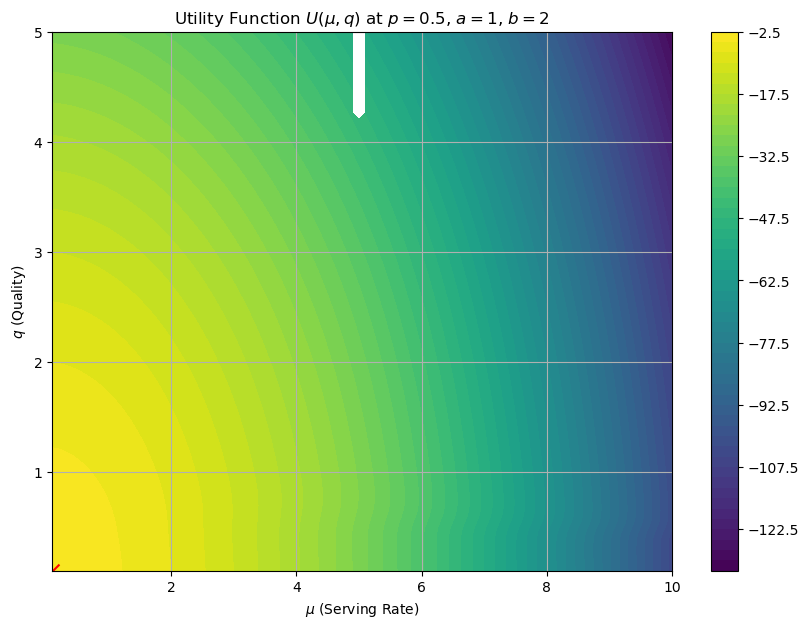

In [33]:
def return_rate(q, a=10, b=0.5):
    return 1 / (1 + np.exp(a * (q - b)))

def utility(mu, q, p, m, B, lam, costa=1, costb=1):
    queue = MMmBQueue(m, B, lam, mu * (1 - return_rate(q)))  # update mu for return rate
    cost = mu**2 + costa*q**2 + costb*mu*q
    nq = queue.expected_nq()
    return -(cost + p * nq)

# hyperparameters
p = 0.5
costa = 1
costb = 0.1

mu_values = np.linspace(0.1, 10, 100)
q_values = np.linspace(0.1, 5, 100)

MU, Q = np.meshgrid(mu_values, q_values)
U = np.zeros_like(MU)

max_index = np.unravel_index(np.argmax(U), U.shape)
max_mu = MU[max_index]
max_q = Q[max_index]
max_u = U[max_index]

# calculate utility for each (mu, q) pairs
for i in range(len(mu_values)):
    for j in range(len(q_values)):
        U[j, i] = utility(MU[j, i], Q[j, i], p, m, B, lam, costa, costb)

plt.figure(figsize=(10, 7))
contour = plt.contourf(MU, Q, U, levels=50, cmap='viridis')
plt.colorbar(contour)
plt.scatter(max_mu, max_q, color='red', marker='x', s=100)
plt.title('Utility Function $U(\\mu, q)$ at $p=0.5$, $a=1$, $b=2$')
plt.xlabel('$\\mu$ (Serving Rate)')
plt.ylabel('$q$ (Quality)')
plt.grid(True)
plt.show()

In [45]:
def utility(mu, q, p, m, B, lam, costa=1, costb=1, a=10, b=0.5):
    queue = MMmBQueue(m, B, lam, mu * (1 - return_rate(q, a, b)))
    cost = mu**2 + costa*q**2 + costb*mu*q
    nq = queue.expected_nq()
    return -(cost + p * nq)

def plot_utility(m, B, lam, p, costa, costb, a, b):
    mu_values = np.linspace(0.1, 10, 100)
    q_values = np.linspace(0.1, 5, 100)
    MU, Q = np.meshgrid(mu_values, q_values)
    U = np.zeros_like(MU)
    
    for i in range(len(mu_values)):
        for j in range(len(q_values)):
            U[j, i] = utility(MU[j, i], Q[j, i], p, m, B, lam, costa, costb, a, b)
    
    # # find the maximum utility point
    # max_index = np.unravel_index(np.argmax(U), U.shape)
    # max_mu = MU[max_index]
    # max_q = Q[max_index]
    # max_u = U[max_index]

    plt.figure(figsize=(10, 7))
    contour = plt.contourf(MU, Q, U, levels=50, cmap='viridis')
    plt.colorbar(contour)
    # plt.scatter(max_mu, max_q, color='red', marker='x', s=100, label=f'Max at $(\mu, q) = ({max_mu:.2f}, {max_q:.2f})$')
    plt.title(f'Utility Function at $lambda={lam}$, $U(\\mu, q)$\n$p={p}$, $cost_a={costa}$, $cost_b={costb}$, $return_a={a}$, $return_b={b}$')
    plt.xlabel('$\\mu$ (Serving Rate)')
    plt.ylabel('$q$ (Quality)')
    plt.legend()
    plt.grid(True)
    plt.show()



/var/folders/bt/8lz5hj4d0fbbslj5lj4c85qm0000gn/T/ipykernel_37336/2239437378.py:15: RuntimeWarning: invalid value encountered in scalar divide
  part_c = (1 - self.rho**(self.B - self.m + 1)) * rho_m**self.m / (factorial(self.m) * (1 - self.rho))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


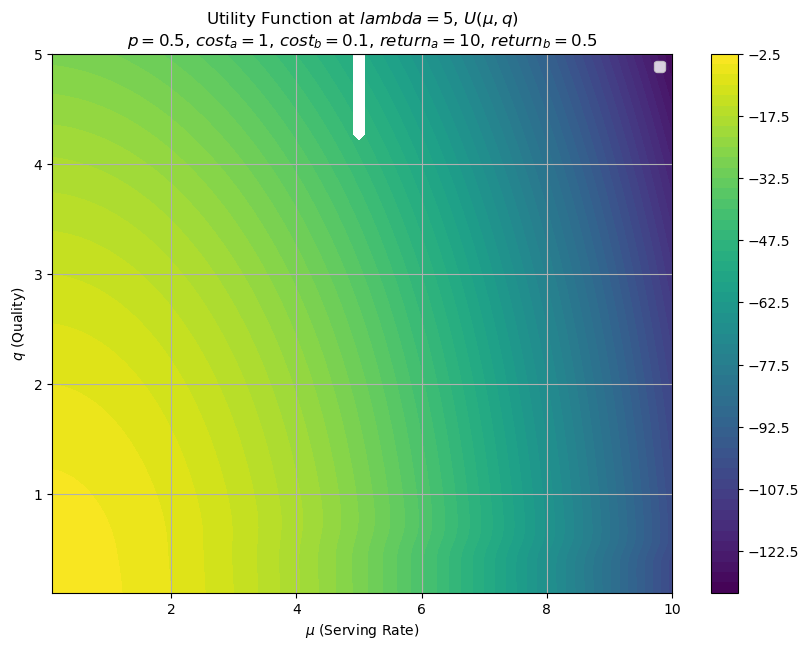

In [46]:
plot_utility(m=3, B=10, lam=5, p=0.5, costa=1, costb=0.1, a=10, b=0.5)

/var/folders/bt/8lz5hj4d0fbbslj5lj4c85qm0000gn/T/ipykernel_37336/2239437378.py:15: RuntimeWarning: invalid value encountered in scalar divide
  part_c = (1 - self.rho**(self.B - self.m + 1)) * rho_m**self.m / (factorial(self.m) * (1 - self.rho))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


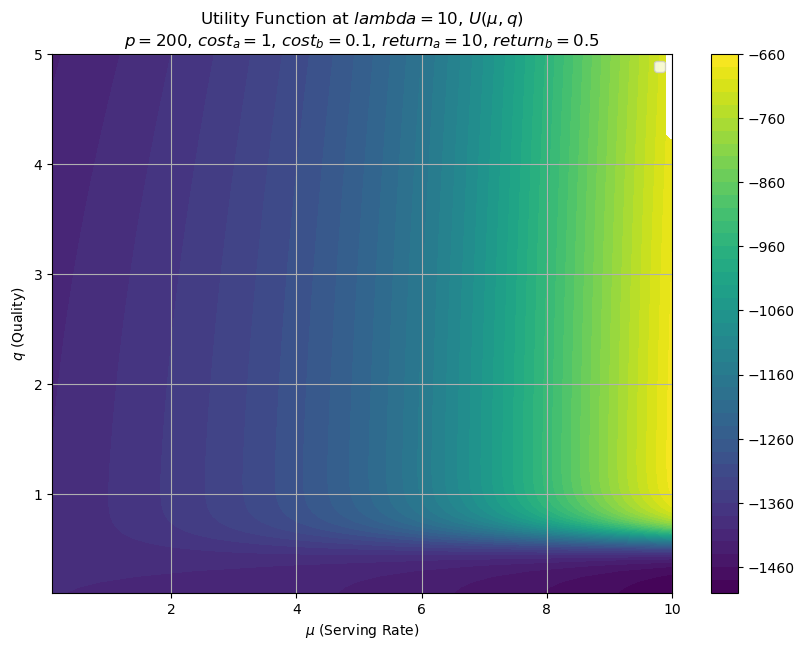

In [54]:
plot_utility(m=3, B=10, lam=10, p=200, costa=1, costb=0.1, a=10, b=0.5)